In [19]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
import cv2
import torch
import torchvision.transforms as transforms
%matplotlib inline

ЗАДАЧА №1

In [20]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = np.tanh(X)
        return self.s
        pass

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydx = 1 - self.s ** 2
        return dLdy * dydx
        pass

    def step(self, learning_rate):
        pass

ЗАДАЧА №2

In [21]:
class Augumentation(torch.nn.Module):
  def __init__(self):
      super().__init__()

  def rotations(self, img):
    random_floats_angles = np.random.uniform(low=-15, high=15, size=1)
    angle_rotation = random_floats_angles[0]
    img = transforms.functional.rotate(img, angle_rotation)
    return img

  def shifts(self, img):
    random_floats_shifts = np.random.uniform(low=-10, high=10, size=2)
    x_shift = random_floats_shifts[0]
    y_shift = random_floats_shifts[1]
    img = transforms.functional.affine(img, angle=0,
                                       translate=[x_shift, y_shift],
                                       scale=1.0,
                                       shear=0.0,
                                       fill=0)

    return img

  def noises(self, img):
    img = transforms.functional.gaussian_blur(img, kernel_size=7)
    return img

  def forward(self, img):
    random_state = np.random.uniform(low=0, high=11, size=1)
    if(random_state <= 2):
      return self.rotations(img)
    elif(random_state > 2 and random_state <=4):
      return self.noises(img)
    elif(random_state>4 and random_state<=6):
      return self.shifts(img)
    else:
      return img

In [22]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

In [23]:
class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

In [24]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [25]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [26]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


In [38]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.295/0.287	Accuracy: 0.922/0.922

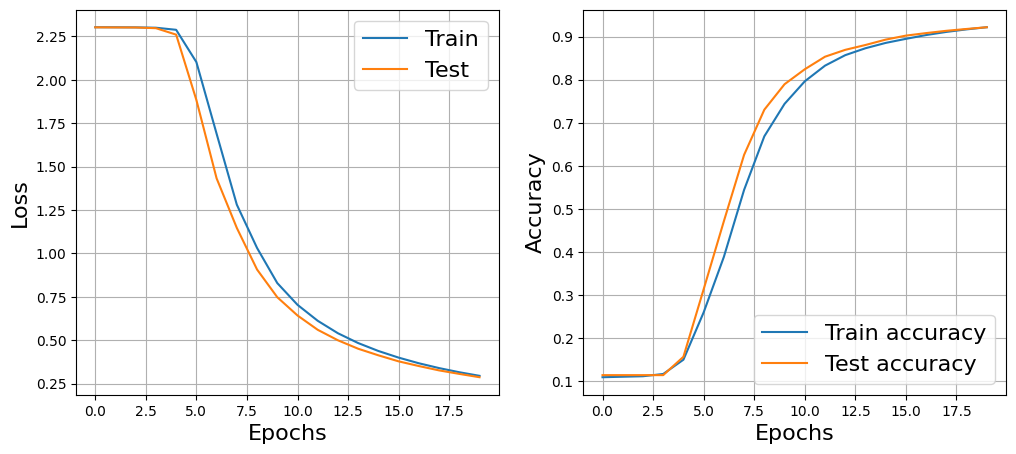

In [17]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()


tr_sigmoid, ts_sigmoid, tr_ac_sigmoid, ts_ac_sigmoid = train(network, 20, 0.01)

Epoch 19... (Train/Test) NLL: 0.038/0.085	Accuracy: 0.989/0.976

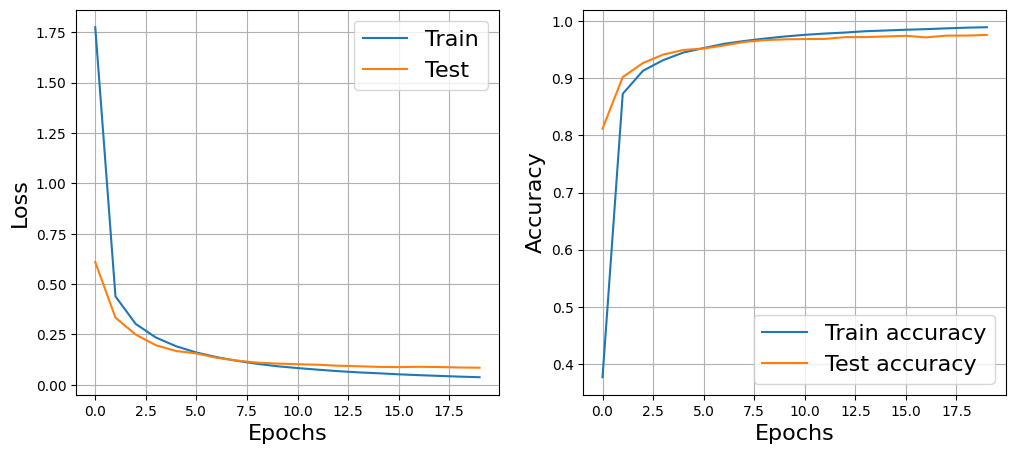

In [29]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(), # 28 * 28
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()


tr_relu, ts_relu, tr_ac_relu, ts_ac_relu = train(network, 20, 0.01)

Epoch 19... (Train/Test) NLL: 0.032/0.078	Accuracy: 0.993/0.975

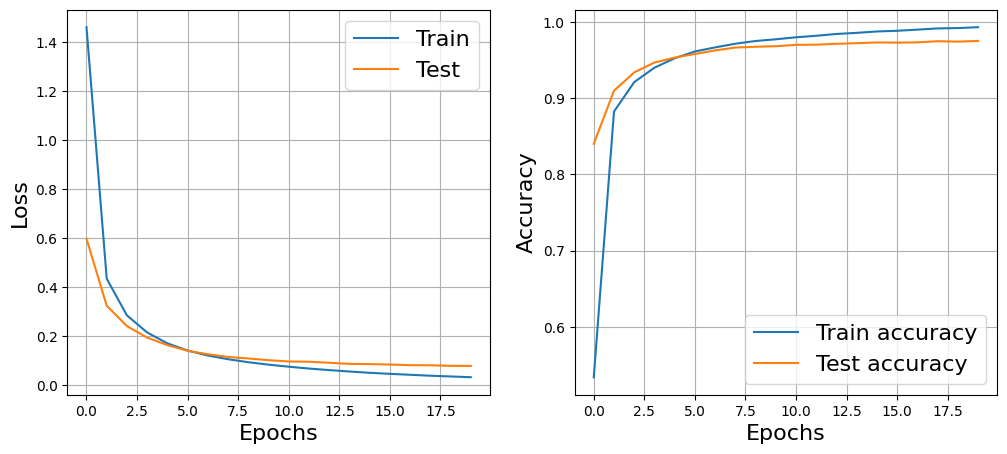

In [30]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()


tr_tanh, ts_tanh, tr_ac_tanh, ts_ac_tanh = train(network, 20, 0.01)

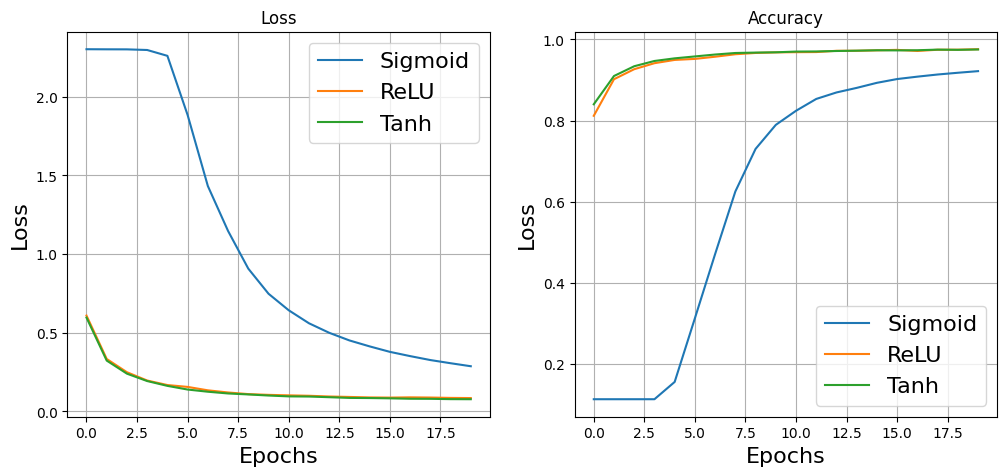

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_sigmoid, label='Sigmoid')
plt.plot(ts_relu, label='ReLU')
plt.plot(ts_tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_sigmoid, label='Sigmoid')
plt.plot(ts_ac_relu, label='ReLU')
plt.plot(ts_ac_tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

ПРОВЕРКА АУГУМЕНТАЦИИ

In [39]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       Augumentation()
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [40]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.221/0.080	Accuracy: 0.930/0.976

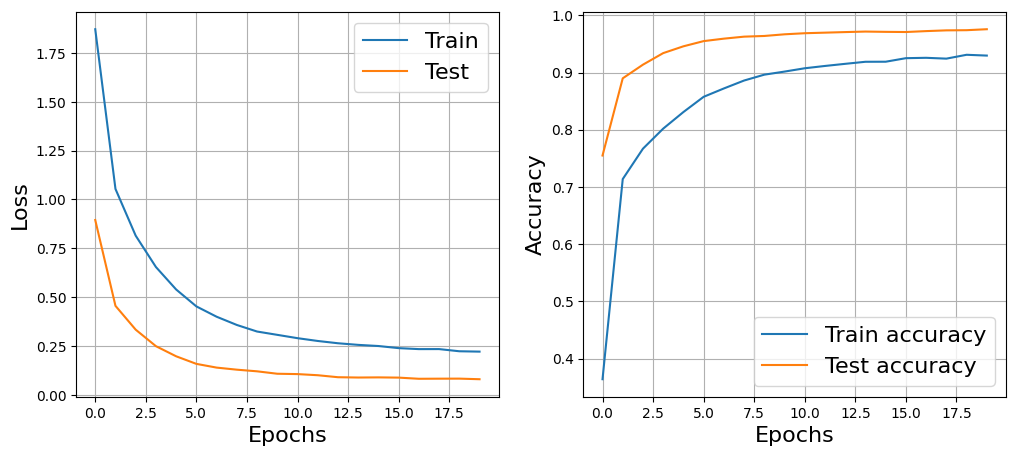

In [41]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()


tr_tanh_a, ts_tanh_a, tr_ac_tanh_a, ts_ac_tanh_a = train(network, 20, 0.01)

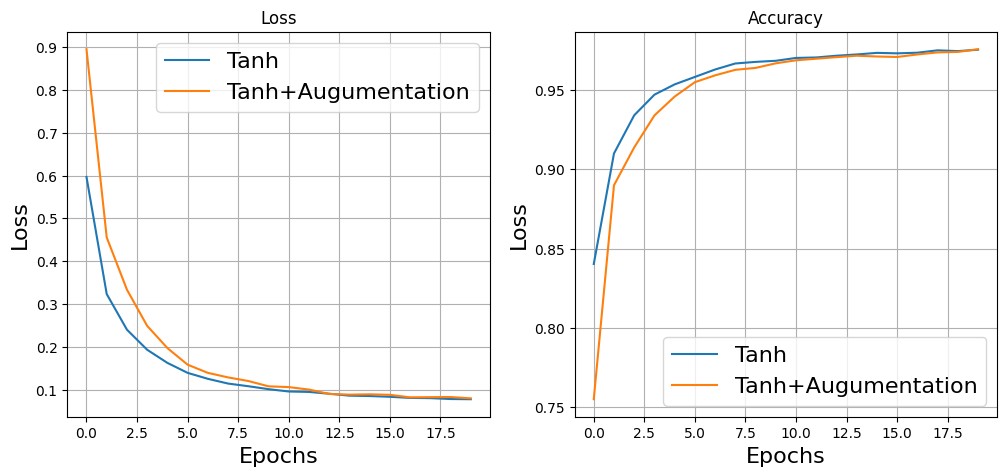

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_tanh, label='Tanh')
plt.plot(ts_tanh_a, label='Tanh+Augumentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_tanh, label='Tanh')
plt.plot(ts_ac_tanh_a, label='Tanh+Augumentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()